In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, RepeatVector, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
data = pd.read_csv('telcox.csv')

## 1. Preprocessing and Data Preparation

In [8]:
N_UNIQUE_ACTS = len(data['activity'].unique()) + 1 

data['start'] = pd.to_datetime(data['start'])
data['end'] = pd.to_datetime(data['end'])

exclude_columns = ["traceId", "index", "activity", "start", "end", "duration", "EVENTID", "VariantId"]

attributes = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
selected_attributes = [attr for attr in attributes if attr not in exclude_columns]

In [9]:
data['activity_list'] = data.groupby('traceId')['activity'].transform(lambda x: [x.tolist()] * len(x))
data['activity_durations'] = data.groupby('traceId')['duration'].transform(lambda x: [x.tolist()] * len(x))

data['next_activity'] = data.groupby('traceId')['activity'].shift(-1)
data['next_start'] = data.groupby('traceId')['start'].shift(-1)

data['transition_duration'] = (data['next_start'] - data['end']).dt.total_seconds().fillna(0).astype(int)
data['transition_durations'] = data.groupby('traceId')['transition_duration'].transform(lambda x: [x.tolist()] * len(x))

data['total_duration'] = data.groupby('traceId')['duration'].transform('sum') + data.groupby('traceId')['transition_duration'].transform('sum')

In [10]:
activity_tokenizer = Tokenizer(filters='', lower=False, split='Ω')
activity_tokenizer.fit_on_texts(data['activity'].unique().tolist())

data['activity_tokenized'] = [seq[0] for seq in activity_tokenizer.texts_to_sequences(data['activity'])]
data['sequence_tokenized'] = activity_tokenizer.texts_to_sequences(data['activity_list'])
data['next_activity_tokenized'] = [seq[0] if seq else -1 for seq in activity_tokenizer.texts_to_sequences(data['next_activity'].fillna('UNKNOWN'))]
data['tokenized_transition'] = data['activity_tokenized'].astype(str) + "->" + data['next_activity_tokenized'].astype(str)

attribute_tokenizers = {}
for attr in selected_attributes:
    tok = Tokenizer(filters='', lower=False, split='Ω')
    tok.fit_on_texts(data[attr].astype(str).tolist())
    sequences = tok.texts_to_sequences(data[attr].astype(str).tolist())
    data[attr] = [seq[0] if seq else -1 for seq in sequences]
    attribute_tokenizers[attr] = tok

In [11]:
data_sequences = data.drop_duplicates(subset='traceId')[['traceId', 'sequence_tokenized', 'activity_durations', 'transition_durations', 'total_duration'] + selected_attributes]

In [12]:
data_sequences

,traceId,sequence_tokenized,activity_durations,transition_durations,total_duration,CCgroup,Center,Contractores,FSresult,OpenWO,Type
0,01be9719-6b2f-4200-b72c-54d085f8af1c,"[1, 2, 3, 4, 5]","[54, 50, 188, 110, 57]","[0, 0, 0, 21256, 0]",21715,3,2,3,1,2,1
5,060404a8-6ef2-4bdf-a489-146940182867,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[54, 2, 95, 19, 4, 80, 1133, 108, 38]","[1707, 87, 3478, 130716, 86200, 98240, 403, 12...",334658,2,1,1,3,1,1
14,061b22a0-9f97-4871-9b02-814d531e25e7,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[56, 8, 175, 75, 52, 25, 4827, 1, 4]","[417, 795, 3500, 111103, 95248, 98014, 267, 24...",338900,3,1,1,1,1,1
23,07a10e2c-c356-405a-bb71-62122ae3efa3,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[53, 15, 60, 46, 138, 92, 2028, 77, 59]","[1540, 189, 3547, 128811, 91879, 81325, 189, 2...",337447,3,1,1,1,1,1
32,0c5ae66d-e82b-447d-9bc5-b46f52419a5b,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[33, 69, 103, 162, 170, 43, 428, 92, 39]","[1278, 2594, 3159, 48364, 80125, 77068, 247, 1...",229530,2,1,3,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...
32365,d9efc47d-e780-4afe-b87f-2259fad5887e,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[55, 29, 262, 166, 77, 49, 5246, 27, 17]","[3338, 1567, 0, 43332, 69515, 97379, 768, 1536...",237187,1,1,1,4,1,4
32374,dd53abfa-5cae-4245-88d6-322b191a9795,"[1, 2, 3, 4, 5]","[16, 115, 289, 82, 40]","[0, 0, 0, 20546, 0]",21088,2,1,2,1,5,1
32379,f13ad972-12ba-4602-ab09-b140750e6398,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[9, 37, 159, 96, 15, 103, 2436, 76, 45]","[1229, 259, 166, 109720, 69260, 91271, 1, 2275...",297637,1,2,1,4,1,1
32388,fecd9b3e-903c-4d20-a8da-9e99f6d62921,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[15, 82, 141, 163, 169, 7, 5276, 98, 17]","[2426, 714, 102, 50346, 67915, 82830, 420, 217...",232451,1,2,2,6,1,4


In [13]:
def truncate_sequence(seq):
    if len(seq) > 1:
        trunc_point = np.random.randint(1, len(seq))
        truncated = seq[:trunc_point]
        remaining = seq[trunc_point:]
    else:
        truncated = seq
        remaining = []
        trunc_point = len(seq)
    return truncated, remaining, trunc_point

def truncate_list(lst, trunc_points, offset=0):
    truncated = [item[:tp - offset] for item, tp in zip(lst, trunc_points)]
    remaining = [item[tp - offset:] for item, tp in zip(lst, trunc_points)]
    return truncated, remaining

data_sequences[['truncated_tokenized', 'remaining_tokenized', 'trunc_point']] = data_sequences['sequence_tokenized'].apply(truncate_sequence).apply(pd.Series)

data_sequences['truncated_durations'], data_sequences['remaining_durations'] = truncate_list(data_sequences['activity_durations'], data_sequences['trunc_point'])
data_sequences['truncated_transitions'], data_sequences['remaining_transitions'] = truncate_list(data_sequences['transition_durations'], data_sequences['trunc_point'], 1)

data_sequences['truncated_total_duration'] = data_sequences['truncated_durations'].apply(sum) + data_sequences['truncated_transitions'].apply(sum)
data_sequences['remaining_total_duration'] = data_sequences['remaining_durations'].apply(sum) + data_sequences['remaining_transitions'].apply(sum)

assert all(data_sequences['truncated_total_duration'] + data_sequences['remaining_total_duration'] == data_sequences['total_duration'])


In [14]:
MAX_SEQ_LENGTH = max(data_sequences['sequence_tokenized'].apply(len))
data_sequences['truncated_tokenized'] = pad_sequences(data_sequences['truncated_tokenized'], maxlen=MAX_SEQ_LENGTH, padding='post').tolist()
data_sequences['remaining_tokenized'] = pad_sequences(data_sequences['remaining_tokenized'], maxlen=MAX_SEQ_LENGTH, padding='post').tolist()

In [15]:
data_sequences

,traceId,sequence_tokenized,activity_durations,transition_durations,total_duration,CCgroup,Center,Contractores,FSresult,OpenWO,Type,truncated_tokenized,remaining_tokenized,trunc_point,truncated_durations,remaining_durations,truncated_transitions,remaining_transitions,truncated_total_duration,remaining_total_duration
0,01be9719-6b2f-4200-b72c-54d085f8af1c,"[1, 2, 3, 4, 5]","[54, 50, 188, 110, 57]","[0, 0, 0, 21256, 0]",21715,3,2,3,1,2,1,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,"[54, 50, 188]","[110, 57]","[0, 0]","[0, 21256, 0]",292,21423
5,060404a8-6ef2-4bdf-a489-146940182867,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[54, 2, 95, 19, 4, 80, 1133, 108, 38]","[1707, 87, 3478, 130716, 86200, 98240, 403, 12...",334658,2,1,1,3,1,1,"[1, 2, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0]","[7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0, 0]",4,"[54, 2, 95, 19]","[4, 80, 1133, 108, 38]","[1707, 87, 3478]","[130716, 86200, 98240, 403, 12294, 0]",5442,329216
14,061b22a0-9f97-4871-9b02-814d531e25e7,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[56, 8, 175, 75, 52, 25, 4827, 1, 4]","[417, 795, 3500, 111103, 95248, 98014, 267, 24...",338900,3,1,1,1,1,1,"[1, 2, 3, 6, 7, 0, 0, 0, 0, 0, 0, 0]","[8, 9, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0]",5,"[56, 8, 175, 75, 52]","[25, 4827, 1, 4]","[417, 795, 3500, 111103]","[95248, 98014, 267, 24333, 0]",116181,222719
23,07a10e2c-c356-405a-bb71-62122ae3efa3,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[53, 15, 60, 46, 138, 92, 2028, 77, 59]","[1540, 189, 3547, 128811, 91879, 81325, 189, 2...",337447,3,1,1,1,1,1,"[1, 2, 3, 6, 7, 8, 9, 0, 0, 0, 0, 0]","[10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7,"[53, 15, 60, 46, 138, 92, 2028]","[77, 59]","[1540, 189, 3547, 128811, 91879, 81325]","[189, 27399, 0]",309723,27724
32,0c5ae66d-e82b-447d-9bc5-b46f52419a5b,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[33, 69, 103, 162, 170, 43, 428, 92, 39]","[1278, 2594, 3159, 48364, 80125, 77068, 247, 1...",229530,2,1,3,4,1,4,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0]",3,"[33, 69, 103]","[162, 170, 43, 428, 92, 39]","[1278, 2594]","[3159, 48364, 80125, 77068, 247, 15556, 0]",4077,225453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32365,d9efc47d-e780-4afe-b87f-2259fad5887e,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[55, 29, 262, 166, 77, 49, 5246, 27, 17]","[3338, 1567, 0, 43332, 69515, 97379, 768, 1536...",237187,1,1,1,4,1,4,"[1, 2, 3, 6, 7, 8, 9, 0, 0, 0, 0, 0]","[10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7,"[55, 29, 262, 166, 77, 49, 5246]","[27, 17]","[3338, 1567, 0, 43332, 69515, 97379]","[768, 15360, 0]",221015,16172
32374,dd53abfa-5cae-4245-88d6-322b191a9795,"[1, 2, 3, 4, 5]","[16, 115, 289, 82, 40]","[0, 0, 0, 20546, 0]",21088,2,1,2,1,5,1,"[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4,"[16, 115, 289, 82]",[40],"[0, 0, 0]","[20546, 0]",502,20586
32379,f13ad972-12ba-4602-ab09-b140750e6398,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[9, 37, 159, 96, 15, 103, 2436, 76, 45]","[1229, 259, 166, 109720, 69260, 91271, 1, 2275...",297637,1,2,1,4,1,1,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0]",3,"[9, 37, 159]","[96, 15, 103, 2436, 76, 45]","[1229, 259]","[166, 109720, 69260, 91271, 1, 22755, 0]",1693,295944
32388,fecd9b3e-903c-4d20-a8da-9e99f6d62921,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[15, 82, 141, 163, 169, 7, 5276, 98, 17]","[2426, 714, 102, 50346, 67915, 82830, 420, 217...",232451,1,2,2,6,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 3, 6, 7, 8, 9, 10, 5, 0, 0, 0, 0]",1,[15],"[82, 141, 163, 169, 7, 5276, 98, 17]",[],"[2426, 714, 102, 50346, 67915, 82830, 420, 217...",15,232436


## 2. Data Splitting
- **Training Set:** 80% of the unique traces.
- **Testing Set:** The remaining 20%.

In [16]:
train_df, test_df = train_test_split(data_sequences, test_size=0.2, random_state=42)

train_df = train_df.sort_values(by='traceId')
test_df = test_df.sort_values(by='traceId')

X_train_features = train_df[selected_attributes].values
X_test_features = test_df[selected_attributes].values

## 3. Data Reshaping and One-hot Encoding

In [17]:
X_train = np.array(train_df['truncated_tokenized'].tolist())
Y_train = np.array(train_df['remaining_tokenized'].tolist())

X_test = np.array(test_df['truncated_tokenized'].tolist())
Y_test = np.array(test_df['remaining_tokenized'].tolist())

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)

In [18]:
# Targets (remaining_duration)
y_train_regression = train_df['remaining_total_duration'].values
y_test_regression = test_df['remaining_total_duration'].values

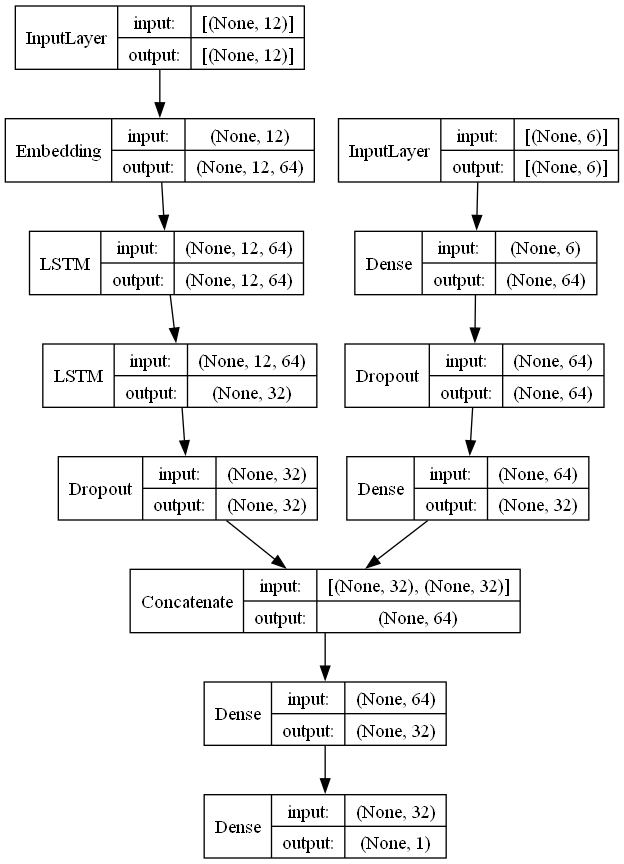

In [19]:
# 1. Sequence Input and Processing
sequence_input = Input(shape=(X_train.shape[1],))
embedded_sequences = Embedding(input_dim=N_UNIQUE_ACTS, output_dim=64)(sequence_input)
lstm_out = LSTM(64, return_sequences=True)(embedded_sequences)
lstm_out = LSTM(32)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)  # Add dropout after LSTM

# 2. Additional Features Input and Processing
feature_input = Input(shape=(X_train_features.shape[1],))
dense_feature = Dense(64, activation='relu')(feature_input)
dense_feature = Dropout(0.2)(dense_feature)  # Add dropout after first Dense layer
dense_feature = Dense(32, activation='relu')(dense_feature)

# 3. Combining the sequence and feature processing paths
combined = Concatenate(axis=-1)([lstm_out, dense_feature])
combined_dense = Dense(32, activation='relu')(combined)

# 4. Regression Output Layer
regression_output = Dense(1, activation='linear')(combined_dense)  # Linear activation for regression

# Create and compile the model
regression_model = Model(inputs=[sequence_input, feature_input], outputs=regression_output)
regression_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.01))

# Display model architecture
plot_model(regression_model, to_file='model.png', show_shapes=True, show_layer_names=False)


In [20]:
# Train the model
regression_history = regression_model.fit([X_train, X_train_features], y_train_regression,
                                         batch_size=32, epochs=50,
                                         validation_data=([X_test, X_test_features], y_test_regression))

Epoch 1/50
112/112 [==============================] - 3s 11ms/step - loss: 123063.8438 - val_loss: 108284.3984
Epoch 2/50
112/112 [==============================] - 1s 7ms/step - loss: 102343.5000 - val_loss: 93403.4141
Epoch 3/50
112/112 [==============================] - 1s 7ms/step - loss: 95789.6172 - val_loss: 93058.4609
Epoch 4/50
112/112 [==============================] - 1s 6ms/step - loss: 95353.6250 - val_loss: 90197.8828
Epoch 5/50
112/112 [==============================] - 1s 6ms/step - loss: 94299.7500 - val_loss: 89304.3984
Epoch 6/50
112/112 [==============================] - 1s 6ms/step - loss: 92678.3047 - val_loss: 89063.3281
Epoch 7/50
112/112 [==============================] - 1s 6ms/step - loss: 92285.6406 - val_loss: 88013.9922
Epoch 8/50
112/112 [==============================] - 1s 6ms/step - loss: 91159.8281 - val_loss: 86861.5859
Epoch 9/50
112/112 [==============================] - 1s 6ms/step - loss: 90501.2188 - val_loss: 86028.9922
Epoch 10/50
112/112 [===

In [36]:
# 1. Predict the remaining duration for both train and test datasets
predicted_remaining_train = regression_model.predict([X_train, X_train_features])
predicted_remaining_test = regression_model.predict([X_test, X_test_features])

# 2. Add the predicted remaining duration to the truncated duration
train_df['predicted_total_duration'] = train_df['truncated_total_duration'] + predicted_remaining_train.flatten()
test_df['predicted_total_duration'] = test_df['truncated_total_duration'] + predicted_remaining_test.flatten()

combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
sla = combined_df['total_duration'].median()

combined_df = combined_df[['traceId', 'total_duration', 'predicted_total_duration']].copy()

def get_risk(total_duration, sla):
    if (total_duration > sla) & (total_duration < sla*1.5):
        return 1
    elif (total_duration > sla*1.5) & (total_duration < sla*2):
        return 2
    elif total_duration > sla*2:
        return 3
    else:
        return 0

combined_df['risk'] = combined_df['total_duration'].apply(lambda x: get_risk(x, sla))
combined_df['risk_predicted'] = combined_df['predicted_total_duration'].apply(lambda x: get_risk(x, sla))
combined_df['correct_prediction'] = combined_df['risk'] == combined_df['risk_predicted']
accuracy_percentage = combined_df['correct_prediction'].mean() * 100

print(f"Accuracy of Predicted Risk: {accuracy_percentage:.2f}%")

ValueError: Data cardinality is ambiguous:
  x sizes: 12, 6
Make sure all arrays contain the same number of samples.

In [24]:
# combined_df = combined_df.drop(columns=['truncated_sequence', 'remaining_sequence', 'remaining_duration', 'truncated_duration'] + selected_attributes)

# def decode_token_sequence(token_sequence, tokenizer):
#     return [tokenizer.index_word[token] for token in token_sequence if token in tokenizer.index_word]

# combined_df['predicted_sequence'] = combined_df['predicted_sequence'].apply(lambda x: decode_token_sequence(x, activity_tokenizer))

In [39]:
# Check if inputs/outputs are in list format
def ensure_list(tensor_or_list):
    return tensor_or_list if isinstance(tensor_or_list, list) else [tensor_or_list]

# Check input names
input_names = [input_layer.name for input_layer in ensure_list(regression_model.input)]
print("Model Input Names:", input_names)

# Check output names
output_names = [output_layer.name for output_layer in ensure_list(regression_model.output)]
print("Model Output Names:", output_names)

Model Input Names: ['input_1', 'input_2']
Model Output Names: ['dense_3/BiasAdd:0']


In [40]:
# import json

# # Convert numpy arrays to lists
# X_train_list = X_train.tolist()
# X_train_features_list = X_train_features.tolist()

# # Structure the data
# instances = []
# for x, feature in zip(X_train_list, X_train_features_list):
#     instance = {
#         "input_1": x,
#         "input_2": feature
#     }
#     instances.append(instance)

# # Create the request payload
# data = {
#     "instances": instances,
#     "parameters": {}  # Add any necessary parameters here, if any
# }

# # Convert the data structure to JSON
# json_data = json.dumps(data)

In [89]:
import requests

token = 'ya29.a0AfB_byBzAHrkwO75F7AQabFlvKhcBXpg0JnWkeh-jViwZby3HeHXw4UpMKhm-7SD33EsV2I_1eN3bsp3vZAxVBN9mxO0EE-zxuUN-x9edPGeY2ci792kddvX-mJztPkFyP2WV_b2DXj4DLpDrpSB7_UE0Y_WRsYSS6h2aCgYKAf0SARASFQGOcNnCf-roZodoVujrZ16UaLJ61w0171'
URL = 'https://us-central1-aiplatform.googleapis.com/v1/projects/onboarding-host-704ada52d0e24d/locations/us-central1/endpoints/5911768358319030272:predict'

# Set headers with the access token
headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json",
}

data = {
    "instances": [
        {
            "input_1": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            "input_2": [3, 2, 4, 2, 1, 3]
        }
    ]
}

# Make the request
response = requests.post(URL, headers=headers, json=data)

# Print the response
print(response.text)

{
  "predictions": [
    [
      229281.969
    ]
  ],
  "deployedModelId": "3109517839397027840",
  "model": "projects/258577224786/locations/us-central1/models/1199987199345426432",
  "modelDisplayName": "time-model",
  "modelVersionId": "1"
}

